In [1]:
import os
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path

sys.path.append(str(Path.cwd().parent / 'scripts'))
sys.path.append(str(Path.cwd().parent / 'non_workflow_scripts'))

from build_thermal_generator_prices import get_extremes, get_price_distribution

In [2]:
path = Path.cwd().parent / 'data' / 'base'

In [3]:
bids = []
offers = []
pns = []
dah = []

for d in tqdm(os.listdir(path)):

    '''
    try:
        bids.append(
            pd.read_csv(path / d / 'bids.csv', index_col=[0,1]
            )
        )
    except FileNotFoundError:
        pass
    try:
        offers.append(
            pd.read_csv(path / d / 'offers.csv', index_col=[0,1]
            )
        )
    except FileNotFoundError:
        pass
    try:
        dah.append(
            pd.read_csv(path / d / 'day_ahead_prices.csv', index_col=0
            )
        )
    except FileNotFoundError:
        pass
    '''

    try:
        pns.append(
            pd.read_csv(path / d / 'physical_notifications.csv', index_col=0
            )
        )
    except FileNotFoundError:
        pass



# offers = pd.concat(offers)
# bids = pd.concat(bids)
pns = pd.concat(pns)
# dah = pd.concat(dah)

100%|██████████| 851/851 [01:12<00:00, 11.81it/s]


In [4]:
bmus = pd.read_csv(Path.cwd().parent / 'data' / 'bmus_prepared.csv', index_col=0)
b = bmus.loc[bmus['carrier'] == 'battery'].index

# bidding_h = h.intersection(bids.columns)
# offering_h = h.intersection(offers.columns)

In [24]:
n = 4800

name = 'AG-HEL00G'


def get_battery_capacities(name, pns):
    """
    Obtain the battery capacities from the physical notifications DataFrame. 
    For charging and discharging, the maximum and minimum values are taken, respectively.
    Energy capacity is assumed to equal the volume of maximum continuous charging.

    Parameters:
    name (str): The name of the battery unit.
    pns (pd.DataFrame): The physical notifications DataFrame containing power data.

    Returns:
    tuple: A tuple containing the power capacity (MW) and energy capacity (MWh).
    """

    power = pns[[name]].dropna()
    power.index = pd.to_datetime(power.index)

    power['date'] = power.index.date

    daily_charging_energies = []

    for date, group in power.groupby('date'):
        charging = group[name] < 0  # Boolean Series: True where charging

        charging_diff = charging.astype(int).diff()
        start_indices = charging_diff[charging_diff == 1].index
        stop_indices = charging_diff[charging_diff == -1].index

        if charging.iloc[0]:
            start_indices = start_indices.insert(0, charging.index[0])

        if charging.iloc[-1]:
            stop_indices = stop_indices.append(pd.Index([charging.index[-1]]))

        if len(start_indices) > 0 and len(stop_indices) > 0:

            if stop_indices[0] < start_indices[0]:
                stop_indices = stop_indices[1:]
            if len(start_indices) > len(stop_indices):
                start_indices = start_indices[:-1]

            charge_start = start_indices[0]
            charge_stop = stop_indices[0]

            charging_period = group.loc[charge_start:charge_stop]

            energy_charged = (charging_period[name] * 0.5).sum()  # Energy in MWh

            daily_charging_energies.append(-energy_charged)
        else:
            daily_charging_energies.append(0.)

    return (
        power[name].abs().max(), # Power capacity in MW
        max(daily_charging_energies) # Energy capacity in MWh
    )


power_caps = []
energy_caps = []

for name in tqdm(b):
    power_cap, energy_cap = get_battery_capacities(name, pns)

    power_caps.append(power_cap)
    energy_caps.append(energy_cap)


  0%|          | 0/66 [00:00<?, ?it/s]

100%|██████████| 66/66 [00:43<00:00,  1.53it/s]


In [25]:
capacities = pd.DataFrame({
        'power_cap[MW]': power_caps,
        'energy_cap[MWh]': energy_caps,
    },
    index=b
)

In [27]:
capacities

,power_cap[MW],energy_cap[MW]
NationalGridBmUnit,,
BFSE01,49.0,79.333333
AG-HLIM01,20.0,19.500000
AG-HLIM02,40.0,39.000000
AG-HLIM03,50.0,71.500000
AG-HLIM04,50.0,60.000000
...,...,...
AG-MSTK01,50.0,589.508333
AG-JSTK02,6.0,10.433333
AG-HSTK02,50.0,62.375000


In [19]:
power = pd.Series({list(d)[0]: list(d.values())[0][0] for d in capacities}, name='power_capacity(MW)')
energy = pd.Series({list(d)[0]: list(d.values())[0][1] for d in capacities}, name='energy_capacity(MWh)')

In [23]:
pd.concat((power, energy), axis=1).sort_values('power_capacity(MW)', ascending=False)

,power_capacity(MW),energy_capacity(MWh)
DOLLB-1,99.0,242.233333
WISHB-1,51.0,383.500000
AG-MSTK01,50.0,589.508333
PILLB-1,50.0,122.450000
LITRB-1,50.0,172.500000
...,...,...
BROAB-1,11.0,36.000000
PNYCB-1,10.0,11.200000
ARNKB-2,10.0,10.000000
BHOLB-1,7.0,31.433333


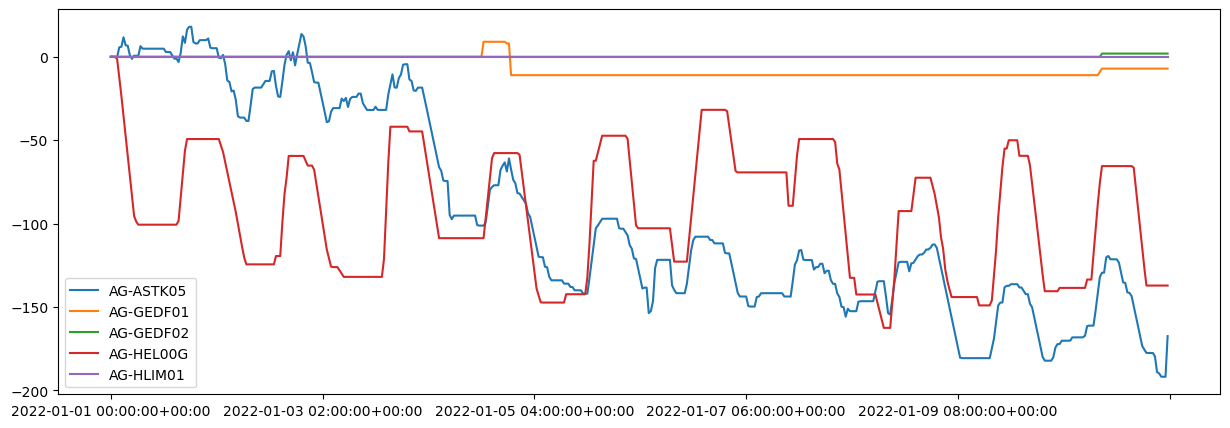

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

cumpn = pns.loc[:, pns.columns.intersection(b)].cumsum()
# pns.loc[:, pns.columns.intersection(b)].iloc[:,:].plot(ax=ax)

cumpn.iloc[:500, :5].plot(ax=ax)


plt.show()

In [62]:
idx = pd.IndexSlice

o = offers.loc[idx[:, 'price'], offering_h].std().sort_values(ascending=True)
o

LCSMH-1        0.000000
FASN-1        78.365161
CAS-GAR01     89.352801
FASN2         97.449252
CAS-KIL01    102.124661
GLNDO-1      102.327558
SLOY-4       105.237621
FASN3        107.684510
SLOY-3       109.949890
NANT-1       130.021871
ERRO-1       141.952180
SLOY-2       145.987576
SLOY-1       148.744301
ERRO-2       150.182155
FINL-1       150.334757
CLAC-1       154.325696
ERRO-3       157.884102
RHEI-4       615.616811
dtype: float64

In [76]:

b = bids.loc[idx[:, 'price'], bidding_h].std().sort_values(ascending=True)
plot_bids = bids.copy().loc[idx[:, 'price'], :]
plot_bids.index = plot_bids.index.droplevel(1)
plot_bids.index = pd.to_datetime(plot_bids.index)
b

FASN-4        0.000000
CAS-CLU01    11.533848
CAS-MOR01    19.309559
LCSMH-1      20.666877
CAS-KIL01    30.158900
CAS-GAR01    31.065319
CAS-BEU01    35.621446
SLOY-4       36.147601
ERRO-1       37.053834
ERRO-2       38.026695
CAS-CON01    40.177711
ERRO-3       41.050082
SLOY-3       42.679298
CLAC-1       45.635594
GLNDO-1      49.563479
NANT-1       49.853070
FASN3        52.120279
SLOY-2       52.248106
FASN2        52.288455
SLOY-1       52.385861
FINL-1       55.273885
FASN-1       56.284019
RHEI-4       90.824604
dtype: float64

In [106]:
wind = bmus.loc[bmus['carrier'] == 'onwind'].index

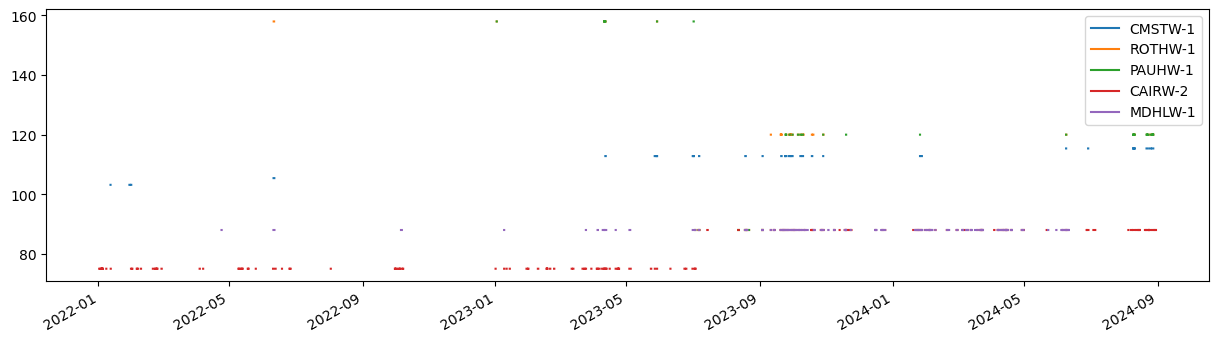

In [110]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(15, 4))
# bids.loc[idx[:, 'price'], b.index[-6:]].plot(ax=ax)

plot_bids.loc[
    :,
    wind.intersection(plot_bids.columns)[:5],
    ].plot(ax=ax)

plt.show()

<Axes: >

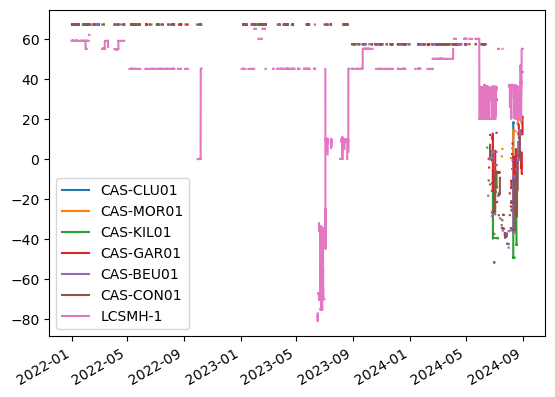

In [113]:
cas = b.index[b.index.str.contains('CAS')].to_list() + ['LCSMH-1']
non_cas = b.index[~b.index.str.contains('CAS')].to_list()
non_cas.remove('LCSMH-1')

plot_bids.loc[
    :,#pd.Timestamp('2023-05-22', tz='utc'):pd.Timestamp('2023-05-25', tz='utc'),
    # ['CAS-MOR01']
    cas
    # non_cas
    # ['ERRO-2', 'ERRO-3'] 
    ].plot()

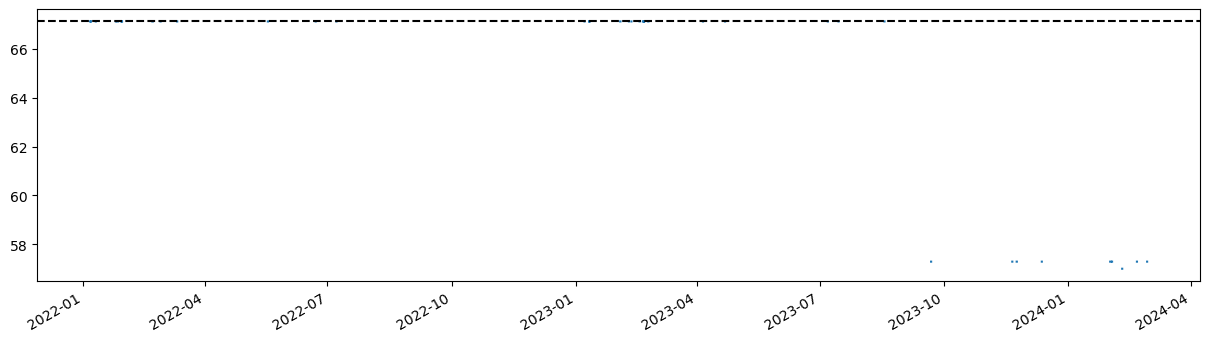

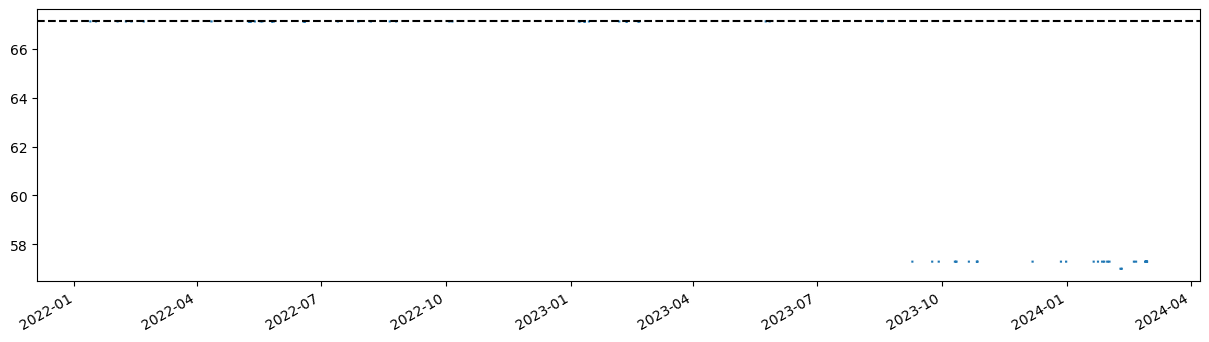

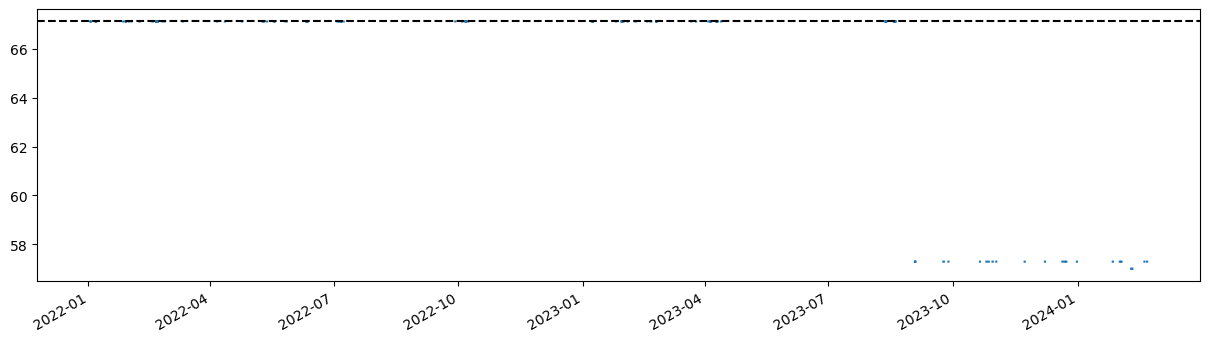

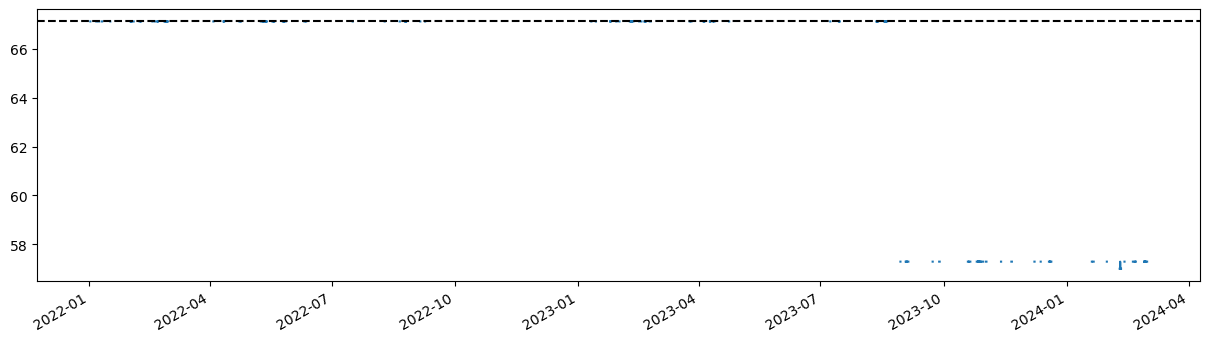

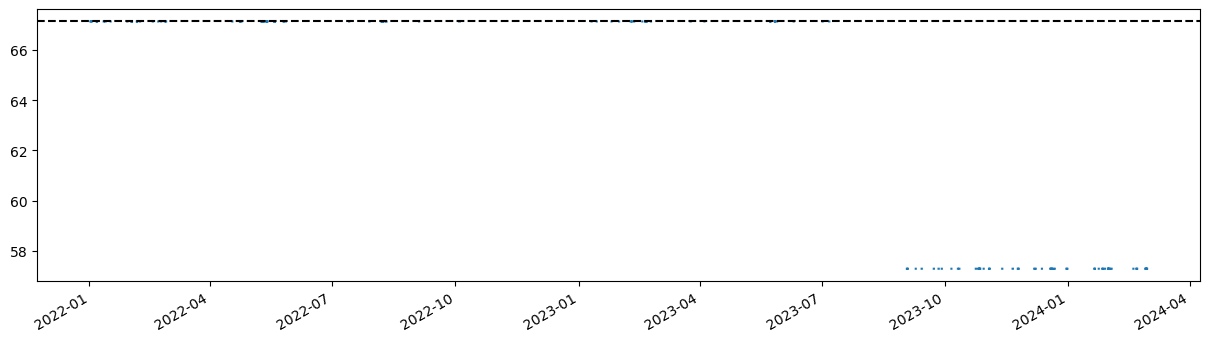

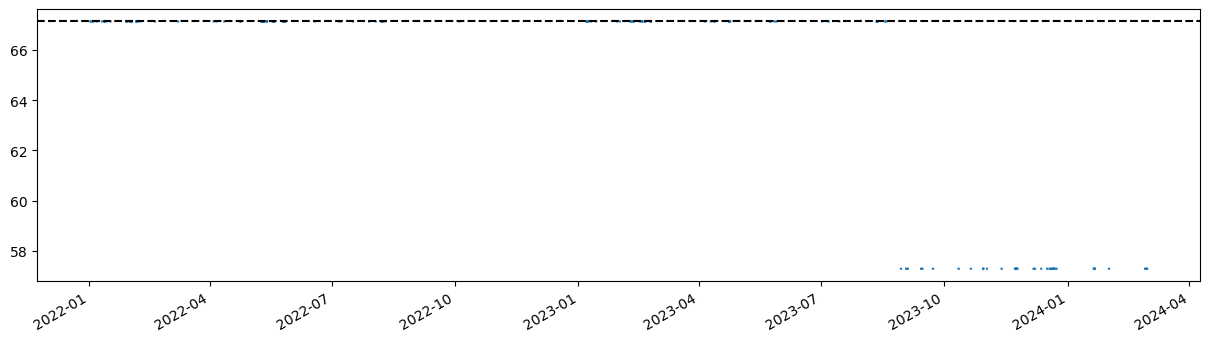

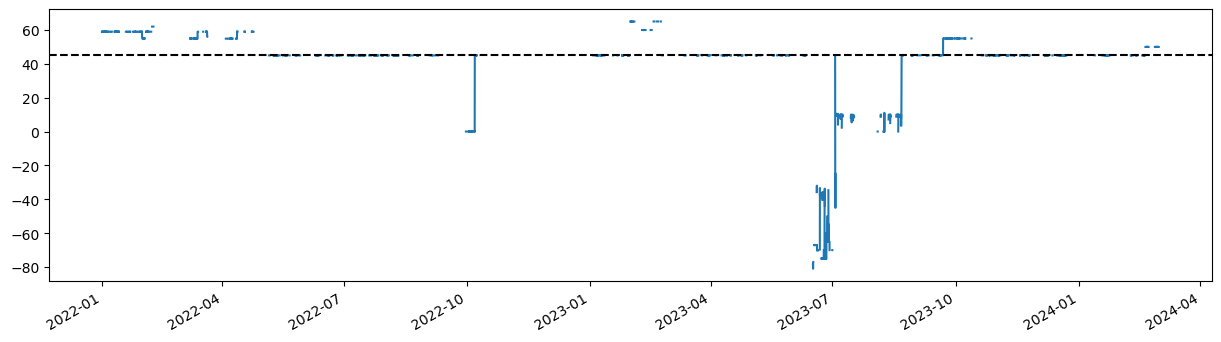

CAS-CLU01    67.13
CAS-MOR01    67.13
CAS-KIL01    67.13
CAS-GAR01    67.13
CAS-BEU01    67.13
CAS-CON01    67.13
LCSMH-1      44.95
dtype: float64


In [143]:
def build_cascading_roc_prices(bids, name):
    
    end_date = pd.Timestamp('2024-03-01', tz='utc')
    bids = bids.copy().loc[:end_date, name]

    roc_value = bids.value_counts().index[0]

    fig, ax = plt.subplots(1, 1, figsize=(15, 4))
    bids.plot(ax=ax)
    ax.axhline(roc_value, color='k', linestyle='--')
    plt.show()

    return roc_value

roc_values = pd.Series(
    {name: build_cascading_roc_prices(plot_bids, name) for name in cas}
)

# build_cascading_roc_prices(plot_bids, 'CAS-MOR01')
# build_cascading_roc_prices(plot_bids, 'LCSMH-1')

print(roc_values)

In [ ]:
# pns.index = pd.to_datetime(pns.index)

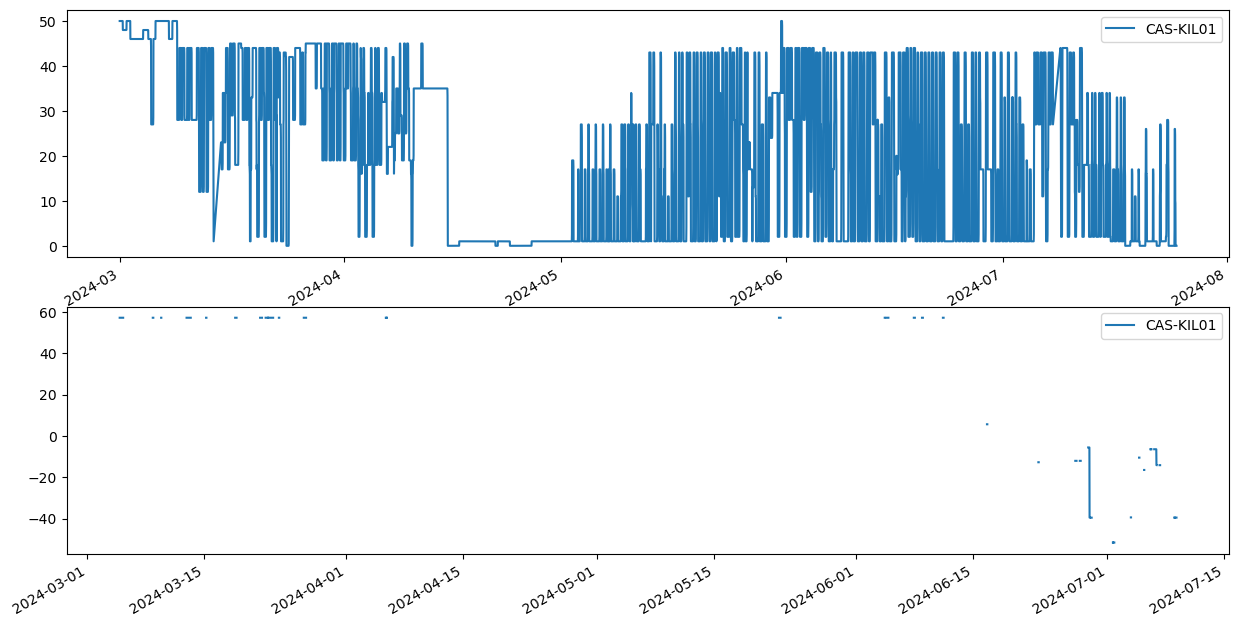

In [119]:
start, end = pd.Timestamp('2024-03-01', tz='utc'), pd.Timestamp('2024-07-25', tz='utc')

fig, ax = plt.subplots(2, 1, figsize=(15, 8))

# index = cas
index = ['CAS-KIL01']
pns[index].loc[start:end].plot(ax=ax[0])
plot_bids[index].loc[start:end].plot(ax=ax[1])

plt.show()

# pns[h].iloc[:500].plot()
# pns['CAS-CLU01'].iloc[1000:2000].plot()
# pns[non_cas].iloc[1000:2000].plot(ax=ax)
# pns['LCSMH-1'].iloc[1000:2000].plot()

In [129]:
bmus.loc[bmus['carrier'] == 'cascade'].index

Index(['LCSMH-1', 'CAS-BEU01', 'CAS-CLU01', 'CAS-CON01', 'CAS-GAR01',
       'CAS-KIL01', 'CAS-MOR01'],
      dtype='object', name='NationalGridBmUnit')

##### Building available generation for hydro and cascade per day

c:\Users\lukas\OneDrive\Desktop\projects\nodal\UKLMP\data\base\2024-03-01\physical_notifications.csv


<Axes: >

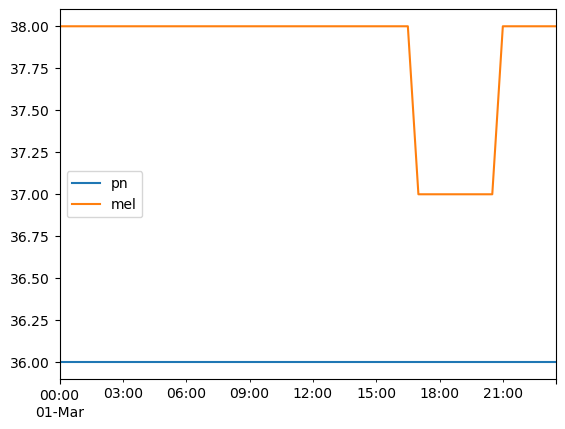

In [149]:
path = Path.cwd().parent / 'data' / 'base'

mock = {
    'pn': str(path / '{}' / 'physical_notifications.csv'),
    'mel': str(path / '{}' / 'maximum_export_limits.csv'),
}

print(mock['pn'].format('2024-03-01'))

def get_generation_volume(name, day):

    pn = (
        pd.read_csv(mock['pn'].format(day), index_col=0, parse_dates=True)
        .rename(columns={name: 'pn'})['pn']
    )
    mel = (
        pd.read_csv(mock['mel'].format(day), index_col=0, parse_dates=True)
        .rename(columns={name: 'mel'})['mel']
    )

    return pn, mel


pd.concat(get_generation_volume('CAS-GAR01', '2024-03-01'), axis=1).plot()

<Axes: >

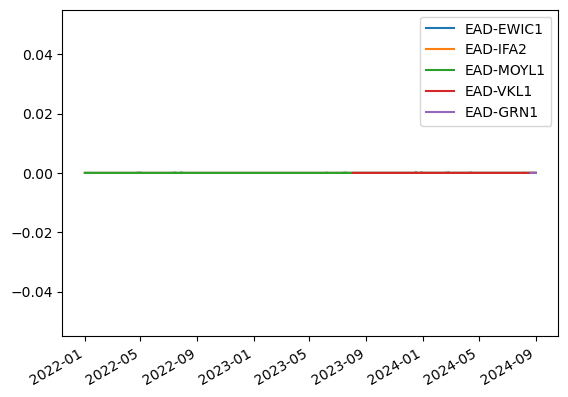

In [158]:
# pns[pns.columns[pns.columns.str.contains('NEMO')]].plot()
# pns['IND-ALIP1'].plot()
pns[pns.columns[pns.columns.str.startswith('EAD')]].plot()

In [1]:
'''
I need a snakemake rule that has a wildcard 'day' in its output
As a an input wildcard it should have the respective week-of-the-year.
It should identify which week the day corresponds to using a lambda function
'''

"\nI need a snakemake rule that has a wildcard 'day' in its output\nAs a an input wildcard it should have the respective week-of-the-year.\nIt should identify which week the day corresponds to using a lambda function\n"

<Axes: >

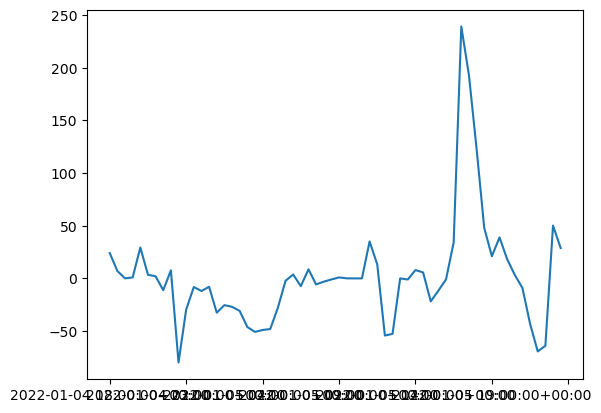

In [36]:
pns[b].iloc[180:240].sum(axis=1).plot()

<Axes: >

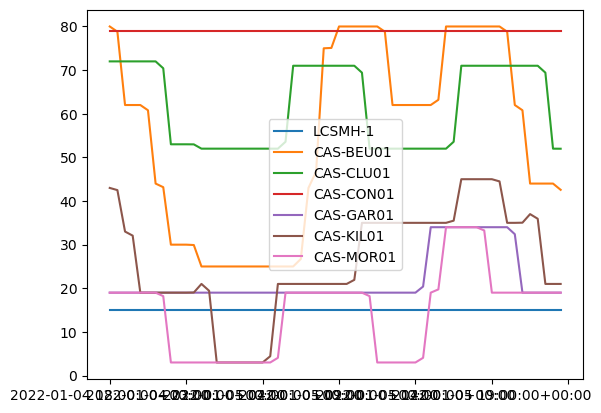

In [38]:
cas = [
    'LCSMH-1',
    'CAS-BEU01',
    'CAS-CLU01',
    'CAS-CON01',
    'CAS-GAR01',
    'CAS-KIL01',
    'CAS-MOR01',
    ]

pns[cas].iloc[180:240].plot()

<Axes: >

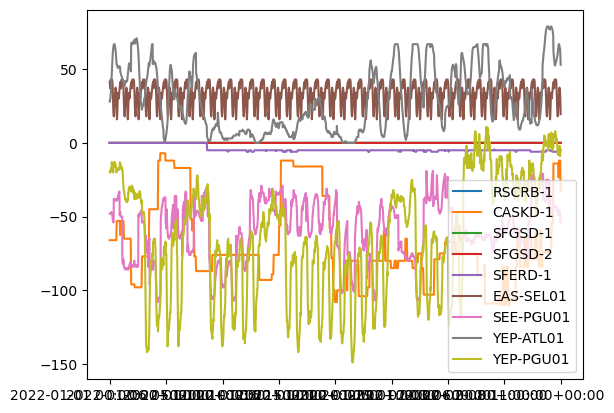

In [43]:
df = bmus.loc[bmus['carrier'] == 'demand_flex'].index
pns[df].iloc[:2000].plot()